In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
n = 1000
m = 3*n
eps = 0.1
data_dim = 2
mu = 5
mu_out = 0
par_mu = np.full(data_dim, mu)
par_sd = np.eye(data_dim)
out_mu = np.full(data_dim, mu_out)
out_sd = np.eye(data_dim)
par_reg1 = 0.0005
par_reg2 = 0.0005
exper_iter = 1
optim_iter = 500
L = 1
learn_par = 0.05
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20

In [16]:
# 分散を単位行列で固定
res = [0 for i in range(exper_iter)]
res_par = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    data_target = np.random.multivariate_normal(mean = par_mu, cov = par_sd, size = int(n*(1-eps)))
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_sd, size = (n - int(n*(1-eps))))
    data = np.concatenate([data_target, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    par_hist = []
    alpha = [np.median(data, axis=0), np.eye(data_dim)]
    z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
    #par = np.random.normal(loc = 0, scale = 0.1, size = 2*data_dim + 1)
    par = alpha[0]
    bias = np.array(np.mean(np.dot(np.stack([z], axis=1).reshape(m, data_dim),par[0:data_dim])))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0)
    for j in range(1, optim_iter+1):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)

        def major_func(par, past_par):
            new_beta = par[0:data_dim]; new_b = par[data_dim]; beta = past_par[0:data_dim]; b = past_par[data_dim]
            A = np.mean(g_lo(np.dot(np.stack([z], axis=1).reshape(m, data_dim),new_beta) - new_b, np.dot(np.stack([z], axis=1).reshape(m, data_dim),beta) - b))
            B = np.mean(g_up(np.dot(np.stack([data], axis=1).reshape(n, data_dim),new_beta) - new_b, np.dot(np.stack([data], axis=1).reshape(n, data_dim),beta) - b))
            reg = np.linalg.norm(new_beta, ord=2)*par_reg1
            return -(A-B -reg)
        l = 0
        while(l<L):
            op = minimize(major_func, x0 = par, args = par)            
            par = op.x
            l+=1
            
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = (z-alpha_m)
        sig_ = sigmoid(np.dot(np.stack([z], axis=1).reshape(m,data_dim),par[0:data_dim ])- par[data_dim])[:,np.newaxis]
        tmp_alpha = alpha_m - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        alpha[0] = tmp_alpha
        alpha_hist.append(alpha[0])
        par_hist.append(par)
    res[i] = alpha_hist
    res_par[i] = par_hist



1/1


In [14]:
def plot():
    mu = np.array(res)
    nppar = np.array(res_par)
    num_graph_row = 3
    plt.figure(figsize=(4*num_graph_row,4*exper_iter))
    half = int(optim_iter/2)
    mean=[]
    for i in (range(exper_iter)):

        #loss of u norm
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +1)
        plt.title("l2 norm of u")

        loss = np.linalg.norm(nppar[i,:, :-1], ord = 2, axis=1)
        plt.plot(range(len(loss)), loss)   

        #bias
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +2)
        plt.title("bias")
        plt.plot(range(len(nppar[i,:,-1])), nppar[i,:, -1])       

        # loss of mu
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +3)
        plt.title("l2 loss")
        loss = np.linalg.norm(mu[i]-par_mu, ord = 2, axis=1)
        mean.append(loss[-1])
        plt.plot(range(len(loss)), loss)
    print("average mean is : %.4f"%np.mean(mean))
    print("average std is  : %.4f"%np.std(mean))

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

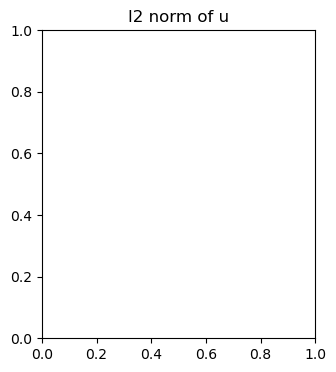

In [15]:
plot()

In [17]:
def plot_2dim(res, res_par,ylim = True):
    mu_result = np.array(res)
    nppar = np.array(res_par)
    num_graph_row = 5
    exper_iter = mu_result.shape[0]
    optim_iter = mu_result.shape[1]
    plt.figure(figsize=(4*num_graph_row,4*exper_iter))
    half = int(optim_iter/2)
    mean=[]
    for i in (range(exper_iter)):
        # mu
        plt.subplot(exper_iter,num_graph_row, num_graph_row*i +1)
        plt.title("estimaterd mu")
        # plt.ylim(4.75, 5.3)
        # plt.xlim(4.75, 5.3)
        plt.scatter(mu_result[i,:half,0], mu_result[i,:half,1], color = "m")
        plt.scatter(mu_result[i,half:,0], mu_result[i,half:,1], color = "c")
        plt.scatter(mu_result[i,0,0], mu_result[i,0,1], c="red")
        plt.scatter(mu_result[i,-1,0], mu_result[i,-1,1], c="blue")
        #plt.scatter(5, 5, color = "black")

        # par1 2
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +2)
        plt.title("parameter of u")
        plt.scatter(nppar[i,half:,0], nppar[i,half:,1], color = "c")
        plt.scatter(nppar[i,:half,0], nppar[i,:half,1], color = "m")
        plt.scatter(nppar[i,0,0], nppar[i,0,1], c="red")
        plt.scatter(nppar[i,-1,0], nppar[i,-1,1], c="blue")


        #loss of u norm
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +3)
        plt.title("l2 norm of u")
        if ylim:
            plt.ylim(0.2,0.8)
        loss = np.linalg.norm(nppar[i,:, :-1], ord = 2, axis=1)
        plt.plot(range(len(loss)), loss)   

        #bias
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +4)
        plt.title("bias")
        plt.plot(range(len(nppar[i,:,-1])), nppar[i,:, -1])       

        # loss of mu
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +5)
        plt.title("l2 loss")
        if ylim:
            plt.ylim(0,0.2)
        loss = np.linalg.norm(mu_result[i]-par_mu, ord = 2, axis=1)
        mean.append(loss[-1])
        plt.plot(range(len(loss)), loss)
    print("average mean is : %.4f"%np.mean(mean))

average mean is : 0.6915


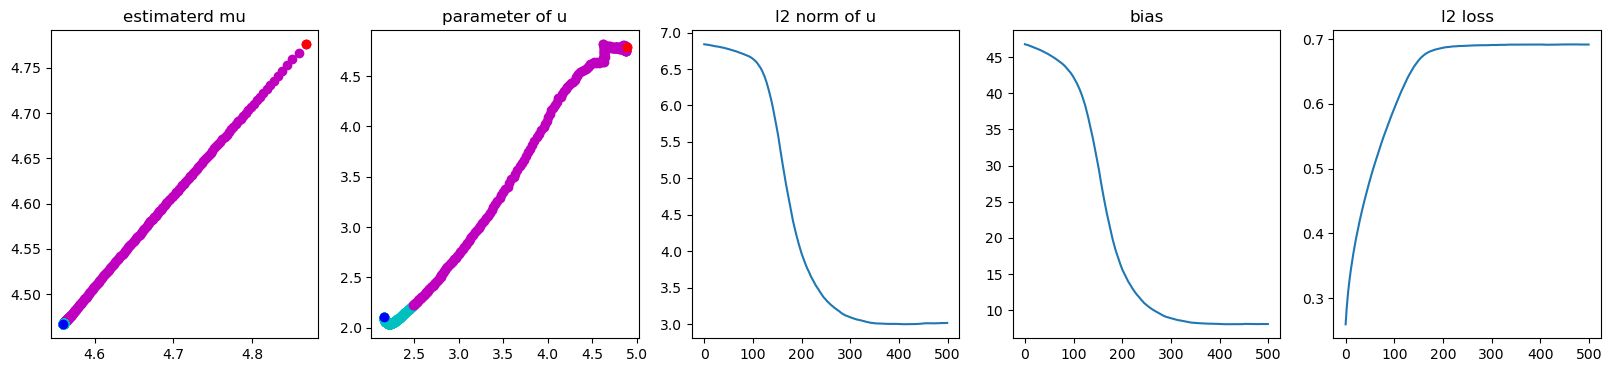

In [18]:
plot_2dim(res, res_par, False)